In [1]:
import os
import json
import glob as glob
import numpy as np
import datetime
import utils
import shutil
import tensorboard
import time
import cv2
import matplotlib.pyplot as plt
import pandas as pd
%load_ext tensorboard
now = datetime.datetime.now()
date_string = now.strftime("%Y-%m-%d_%H-%M-%S")
!mkdir logs_yolo/yolov5-{date_string}
curr_dir = f'logs_yolo/yolov5-{date_string}'
np.random.seed(2024)

In [2]:
t1 = time.perf_counter()

In [3]:
TRAIN = True
EPOCHS = 200
star = 10
BH = 1
num_photo = 500
batch_size = 16
size = 1024
BH_lower = 64
BH_upper = 75
wl = 100e-9
D = 6.5
F = 131.4
angular_pixel_size_input_image = 0.0001

In [4]:
data_dirs = glob.glob(f"/mnt/c/fyq/tele_datasets/stars{star}_BH{BH}_num{num_photo}_rect_wl{wl:.3e}_*{F}*{angular_pixel_size_input_image}*_BHSize{BH_lower}:{BH_upper}")
assert len(data_dirs) != 0, 'Empty'
assert len(data_dirs) == 1, "Please specify more parameters!"
data_dir = data_dirs[0]
data_dir

'/mnt/c/fyq/tele_datasets/stars10_BH1_num500_rect_wl1.000e-07_D6.50_F131.4_AS0.0001_BHSize64:75'

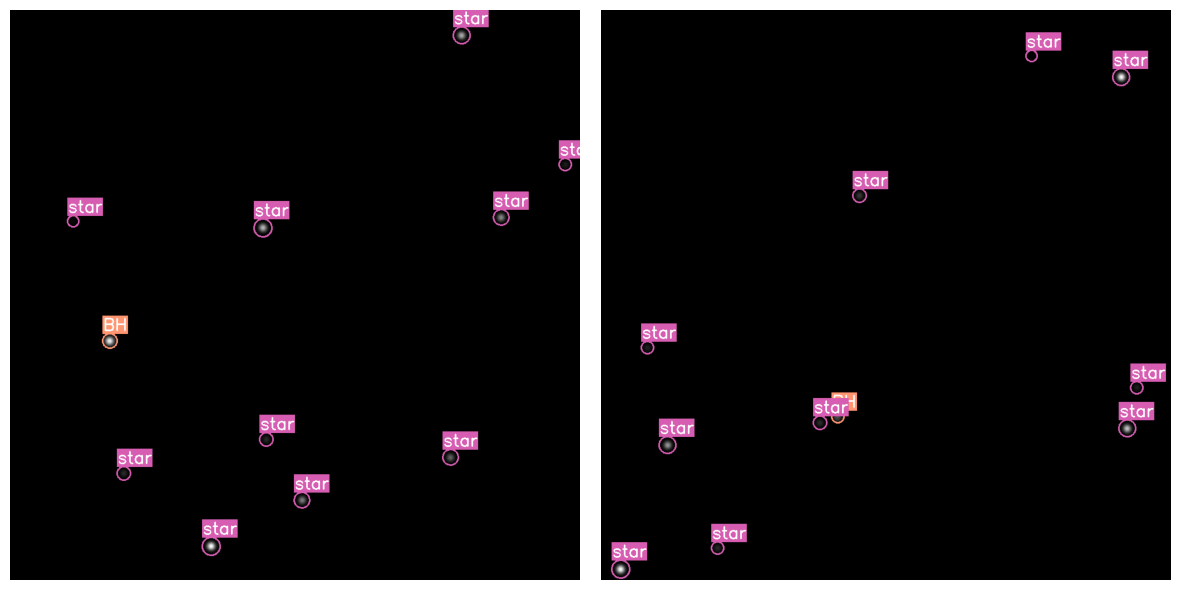

In [5]:
# Visualize a few training images.
utils.labels_plot(
    image_paths=f'{data_dir}/train/images/*',
    label_paths=f'{data_dir}/train/labels/*',
    num_samples=2, curr_dir=curr_dir
)

In [6]:
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

In [7]:
%tensorboard --logdir yolov5/runs/train

In [8]:
%cd yolov5

/home/fyq/deepshadow/yolov5


In [9]:
RES_DIR = set_res_dir()
# yolov5s.pt
if TRAIN:
    !python train.py --data {data_dir}/data.yaml --weights yolov5s.pt --img {size} --epochs {EPOCHS} \
        --batch-size {batch_size} --name {RES_DIR} --cache
else:
    !python train.py --weights yolov5s.pt --data {data_dir}/data.yaml --img {size} \
        --batch-size {batch_size} --name {RES_DIR} --evolve 1000 --cache

Current number of result directories: 0
results_1
train: weights=yolov5s.pt, cfg=, data=/mnt/c/fyq/tele_datasets/stars10_BH1_num500_rect_wl1.000e-07_D6.50_F131.4_AS0.0001_BHSize64:75/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=200, batch_size=16, imgsz=1024, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=results_1, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2024-1-18 Python-3.9.18 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForc

In [10]:
# Function to show validation predictions saved during training.
def show_valid_results(RES_DIR):
    !ls runs/train/{RES_DIR}
    EXP_PATH = f"runs/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

In [11]:
# Helper function for inference on images.
def inference(RES_DIR, data_path):
    # Directory to store inference results.
    infer_dir_count = len(glob.glob('runs/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Inference on images.
    !python detect.py --weights runs/train/{RES_DIR}/weights/best.pt \
    --source {data_path} --name {INFER_DIR}
    return INFER_DIR

In [12]:
def visualize(INFER_DIR):
# Visualize inference images.
    INFER_PATH = f"runs/detect/{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*.jpg")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

In [13]:
RES_DIR

'results_1'

In [14]:
!rm -rf ../inference/*

In [15]:
inference_lst = list(np.random.choice(os.listdir(f"{data_dir}/train/images"), 10))

In [16]:
for i in inference_lst:
    !cp {data_dir}/train/images/{i} ../inference/{i}

In [17]:
inference(RES_DIR, '../inference')

Current number of inference detection directories: 0
inference_1
detect: weights=['runs/train/results_1/weights/best.pt'], source=../inference, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=inference_1, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 2024-1-18 Python-3.9.18 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)

Fusing layers... 


Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/10 /home/fyq/deepshadow/inference/BHs_1325e1ca-5a6e-4d88-9ea0-961cbcdc0419.png: 640x640 10 stars, 1 BH, 9.4ms
image 2/10 /home/fyq/deepshadow/inference/BHs_19b40b3b-e7aa-40df-aab9-a35da1a6571b.png: 640x640 8 stars, 1 BH, 6.2ms
image 3/10 /home/fyq/deepshadow/inference/BHs_3ba04193-ab9c-4020-ba2d-90d2034c3ab2.png: 640x640 11 stars, 5.0ms
image 4/10 /home/fyq/deepshadow/inference/BHs_4dfc87f6-3262-4968-8966-e9aa7083965c.png: 640x640 8 stars, 3 BHs, 5.2ms
image 5/10 /home/fyq/deepshadow/inference/BHs_4e794d6d-690f-4384-b224-ba66da5d0300.png: 640x640 9 stars, 1 BH, 5.6ms
image 6/10 /home/fyq/deepshadow/inference/BHs_530ef77b-66c3-4297-9b12-f7f67b18896a.png: 640x640 10 stars, 1 BH, 5.6ms
image 7/10 /home/fyq/deepshadow/inference/BHs_76d6101b-0061-43e5-b9fb-eb5b444bf229.png: 640x640 10 stars, 1 BH, 6.1ms
image 8/10 /home/fyq/deepshadow/inference/BHs_8df3ef32-086a-40a9-a815-3522b61cbc80.png: 640x640 10 stars, 1 BH

'inference_1'

In [18]:
t2 = time.perf_counter()

In [19]:
shutil.move('runs/', f'../{curr_dir}')

'../logs_yolo/yolov5-2024-01-25_15-12-47/runs'

In [20]:
curr_dir

'logs_yolo/yolov5-2024-01-25_15-12-47'

In [21]:
result = pd.read_csv(glob.glob(f'../{curr_dir}/**/*/results*.csv', recursive=True)[-1])
result.columns = result.columns.str.strip()
df_sorted = result.sort_values(by='metrics/mAP_0.5', ascending=False)
best = df_sorted.iloc[0, :]

In [22]:
box_loss = best['val/box_loss']
obj_loss = best['val/obj_loss']
cls_loss = best['val/cls_loss']
precision= best['metrics/precision']
recall = best['metrics/recall']
mAP_05 = best['metrics/mAP_0.5']
mAP_0595 = best['metrics/mAP_0.5:0.95']

In [23]:
# !cat {data_dir}/tele_config.json

In [24]:
with open(f"{data_dir}/telescope_config.json", "r") as json_file:
    telescope_config = json.load(json_file)

with open(f"{data_dir}/stars_config.json", "r") as json_file:
    stars_config = json.load(json_file)

In [25]:
a = {
    'Model_name': 'yolov5',
    'Batch_size': batch_size,
    'Resolution': size,
    'date': date_string,
    'Training Epoch': EPOCHS,
    'box_loss' : box_loss,
    'obj_loss' : obj_loss,
    'cls_loss' : cls_loss,
    'precision' : precision,
    'recall' : recall,
    'mAP_0.5' : mAP_05,
    'mAP_0.5:0.95': mAP_0595,
    'No. training': num_photo / 5 *4,
    'No. testing': num_photo / 5,
    'No. star': star,
    'No. BH': BH,
    'Time': t2 - t1,
    'BH_lower_size': stars_config['BHS_lower_size'],
    'BH_upper_size': stars_config['BH_upper_size'],
    'angular_pixel_size_input_image': telescope_config['angular_pixel_size_input_image'],
    'D': telescope_config['telescope_diameter_m'],
    'F': telescope_config['telescope_focal_length_m'],
    'wavelength': telescope_config['wavelength'],
    'init_size': 3072,
    'CCD_pixel_size': telescope_config['CCD_pixel_size'],
    'CCD_pixel_count': telescope_config['CCD_pixel_count']
}

df = pd.read_excel('../logs_yolo/results.xlsx')
df = pd.concat([df, pd.DataFrame([a])], ignore_index=True)
df.to_excel('../logs_yolo/results.xlsx', index=False)

In [26]:
df

,date,Model_name,Batch_size,Resolution,No. training,No. testing,Training Epoch,More,box_loss,obj_loss,...,Time,BH_lower_size,BH_upper_size,init_size,wavelength,D,F,angular_pixel_size_input_image,CCD_pixel_size,CCD_pixel_count
0,2024-01-15_08-31-37,yolov5,32,1000,NaN,NaN,200,NaN,0.010316,0.070310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-15_13-43-25,yolov5,32,900,NaN,NaN,300,NaN,0.008457,0.055789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-18_14-59-05,yolov5,16,1000,NaN,NaN,300,NaN,0.009994,0.083809,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-18_17-38-36,yolov7,8,800,400.0,100.0,300,NaN,0.035080,0.017080,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-18_21-19-40,yolov5,16,1000,800.0,200.0,300,NaN,0.009994,0.083809,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2024-01-18_23-03-06,yolov5,16,1000,4000.0,1000.0,2000,NaN,0.009792,0.080352,...,1903.525178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2024-01-19_09-33-44,yolov5,16,1000,4000.0,1000.0,250,NaN,0.010062,0.084277,...,1464.442135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2024-01-19_20-42-32,yolov5,16,1000,8000.0,2000.0,200,NaN,0.005050,0.005558,...,22788.763659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2024-01-20_09-44-30,yolov5,16,1000,800.0,200.0,200,NaN,0.008687,0.026217,...,2349.951691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2024-01-20_11-05-05,yolov5,16,1000,4000.0,1000.0,200,NaN,0.006175,0.019700,...,24697.725679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
